In [40]:
import pandas as pd

donations = pd.read_csv('donations.csv')
essays = pd.read_csv('essays.csv')
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')
resources = pd.read_csv('resources.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [41]:
df = projects.merge(outcomes[['projectid', 'fully_funded']], on='projectid', how='left')
df = df.merge(essays[['projectid', 'title', 'short_description', 'need_statement', 'essay']], on='projectid', how='left')


resources_summary = resources.groupby('projectid').agg({
    'item_unit_price': ['sum', 'mean', 'max'],
    'item_quantity': ['sum', 'mean'],
    'project_resource_type': pd.Series.nunique
})
resources_summary.columns = [
    'resource_cost_sum', 'resource_price_avg', 'resource_price_max',
    'item_quantity_sum', 'item_quantity_avg', 'resource_type_count'
]
resources_summary = resources_summary.reset_index()

df = df.merge(resources_summary, on='projectid', how='left')
df

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,title,short_description,need_statement,essay,resource_cost_sum,resource_price_avg,resource_price_max,item_quantity_sum,item_quantity_avg,resource_type_count
0,316ed8fb3b81402ff6ac8f721bb31192,42d43fa6f37314365d08692e08680973,c0e6ce89b244764085691a1b8e28cb81,6.362701e+10,36.576340,-119.608713,Selma,CA,93662.0,NaN,...,Multiculturalism in Literacy,Can we read one more chapter? Do we have to go...,My students need 3 novel sets with multicultur...,Can we read one more chapter? Do we have to go...,14.40,4.80,5.10,99.0,33.00,1.0
1,90de744e368a7e4883223ca49318ae30,864eb466462bf704bf7a16a585ef296a,d711e47810900c96f26a5d0be30c446d,4.837020e+11,32.911179,-96.723640,Dallas,TX,75243.0,urban,...,Reading is the Window to the World!,Engaging reading materials sent right to my st...,My students need exciting reading materials li...,Engaging reading materials sent right to my st...,83.44,10.43,47.32,50.0,6.25,1.0
2,32943bb1063267de6ed19fc0ceb4b9a7,37f85135259ece793213aca9d8765542,665c3613013ba0a66e3a2a26b89f1b68,4.103270e+11,45.166039,-122.414576,Colton,OR,97017.0,rural,...,A Little Tech Goes A Long Way,Our second grade in rural Oregon is an adventu...,My students need an iPad Mini.,Our second grade in rural Oregon is an adventu...,379.99,379.99,379.99,1.0,1.00,1.0
3,bb18f409abda2f264d5acda8cab577a9,2133fc46f951f1e7d60645b0f9e48a6c,4f12c3fa0c1cce823c7ba1df57e90ccb,3.600153e+11,40.641727,-73.965655,Brooklyn,NY,11226.0,urban,...,"Provide Content Aligned, Leveled Texts, For Sc...",Help give 12 Brooklyn students access and orga...,My students need social studies literature res...,Help give 12 Brooklyn students access and orga...,538.00,269.00,329.00,2.0,1.00,1.0
4,24761b686e18e5eace634607acbcc19f,867ff478a63f5457eaf41049536c47cd,10179fd362d7b8cf0e89baa1ca3025bb,6.227100e+10,34.043939,-118.288371,Los Angeles,CA,90006.0,urban,...,Multi-Media Cart,Technology is changing the world as we speak. ...,My students need a multi-media workstation car...,Technology is changing the world as we speak. ...,341.98,170.99,278.99,2.0,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664093,a7236ea96c812895cafc5d700d779147,c4f90a541cb81e68cd7ad180309985ae,a1e14d253e77ffccc074705527845b4a,3.600081e+11,40.809677,-73.939178,New York,NY,10037.0,urban,...,Weather Station for K-6,My name is Mary Reide. I am a New York City T...,"The cost of this proposal is [price], includin...",My name is Mary Reide. I am a New York City T...,0.00,NaN,NaN,0.0,NaN,1.0
664094,e02da37beb332eb66c2d2ba989c597ad,d95c94eea994274d614be50bddd89973,bbd70e92262f0f0a342df5d1f3119d8e,3.600097e+11,40.701778,-74.011840,New York,NY,10004.0,urban,...,Spending and Marketing Study to be Conducted b...,I teach economics to 25 students at Satellite ...,"The cost of this proposal is $1377, including ...",I teach economics to 25 students at Satellite ...,0.00,NaN,NaN,0.0,NaN,1.0
664095,82e536f14eadf2671a70e03416f695a3,b00d2790934ce7487c99bc9d6e1d5d4d,0c5b1a4b6985dcd42c72b732c774474c,3.600077e+11,40.770233,-73.950760,New York,NY,10075.0,urban,...,Provide Special Needs Students with Opportunit...,I just returned from 3 weeks in S. Africa. I w...,"The cost of this proposal is [price], includin...",I just returned from 3 weeks in S. Africa. I ...,0.00,NaN,NaN,0.0,NaN,1.0
664096,e139df754a873a62d93daa56acbf8040,e5476c2ef97b33614445a17554535adc,a81c26262a3ad70702a8f14e5329b023,3.600077e+11,40.765517,-73.960090,New York,NY,10065.0,NaN,...,Who Says Talking to Yourself Is Crazy?: Model...,I teach 9th grade Humanities at Vanguard High ...,"The cost of this proposal is [price], includin...",I teach 9th grade Humanities at Vanguard High ...,0.00,NaN,NaN,0.0,NaN,1.0


In [42]:
# Drop columns with too many missing values
missing_pct = df.isnull().mean().sort_values(ascending=False)
cols_to_drop = missing_pct[missing_pct > 0.4].index
df = df.drop(columns=cols_to_drop)

# Drop rows with missing labels
df = df.dropna(subset=['fully_funded'])


# Fill other NaNs with median
df = df.fillna({
    'students_reached': df['students_reached'].median(),
    'total_price_including_optional_support': df['total_price_including_optional_support'].median()
})

df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

df['essay_length'] = df['essay'].astype(str).apply(len)
df['title_length'] = df['title'].astype(str).apply(len)
df['need_statement_length'] = df['need_statement'].astype(str).apply(len)
df['short_description_length'] = df['short_description'].astype(str).apply(len)

df['month_posted'] = df['date_posted'].dt.month
df['year_posted'] = df['date_posted'].dt.year
df['fully_funded_bin'] = df['fully_funded'].map({'t': 1, 'f': 0})


df.to_csv('processed_data.csv', index=False)
df

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,item_quantity_sum,item_quantity_avg,resource_type_count,essay_length,title_length,need_statement_length,short_description_length,month_posted,year_posted,fully_funded_bin
44772,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,...,16.0,1.000000,1.0,1334,34,64,197,12,2013,1
44773,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,...,3.0,1.000000,1.0,1109,24,95,198,12,2013,0
44774,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,...,4.0,1.333333,1.0,2297,17,159,197,12,2013,0
44775,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,...,6.0,3.000000,1.0,1015,20,100,192,12,2013,0
44776,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,...,5.0,1.000000,1.0,1937,24,207,198,12,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664093,a7236ea96c812895cafc5d700d779147,c4f90a541cb81e68cd7ad180309985ae,a1e14d253e77ffccc074705527845b4a,3.600081e+11,40.809677,-73.939178,New York,NY,10037.0,urban,...,0.0,NaN,1.0,1345,23,75,197,9,2002,1
664094,e02da37beb332eb66c2d2ba989c597ad,d95c94eea994274d614be50bddd89973,bbd70e92262f0f0a342df5d1f3119d8e,3.600097e+11,40.701778,-74.011840,New York,NY,10004.0,urban,...,0.0,NaN,1.0,2271,66,263,194,9,2002,1
664095,82e536f14eadf2671a70e03416f695a3,b00d2790934ce7487c99bc9d6e1d5d4d,0c5b1a4b6985dcd42c72b732c774474c,3.600077e+11,40.770233,-73.950760,New York,NY,10075.0,urban,...,0.0,NaN,1.0,1239,62,75,198,9,2002,1
664096,e139df754a873a62d93daa56acbf8040,e5476c2ef97b33614445a17554535adc,a81c26262a3ad70702a8f14e5329b023,3.600077e+11,40.765517,-73.960090,New York,NY,10065.0,NaN,...,0.0,NaN,1.0,2272,150,75,194,9,2002,1


In [43]:
print("Number of projects:", df.shape[0])
print("Columns:", df.shape[1])
print(df['fully_funded'].value_counts(normalize=True))


Number of projects: 619326
Columns: 53
fully_funded
t    0.695406
f    0.304594
Name: proportion, dtype: float64


In [44]:
print("Poverty level")
print(df['poverty_level'].value_counts())

print("\nGrade level")
print(df['grade_level'].value_counts())

print("\nSubject")
print(df['primary_focus_area'].value_counts())

print("\nStates")
print(df['school_state'].value_counts().head(10))


Poverty level
poverty_level
highest poverty     358324
high poverty        161937
moderate poverty     83797
low poverty          15268
Name: count, dtype: int64

Grade level
grade_level
Grades PreK-2    228733
Grades 3-5       190686
Grades 6-8       106957
Grades 9-12       92943
Name: count, dtype: int64

Subject
primary_focus_area
Literacy & Language    279789
Math & Science         151693
Music & The Arts        55952
Applied Learning        46645
Special Needs           39011
History & Civics        29442
Health & Sports         16758
Name: count, dtype: int64

States
school_state
CA    118506
NY     69823
NC     41196
IL     37922
TX     37200
FL     28033
SC     17587
IN     16043
OK     14101
GA     13736
Name: count, dtype: int64


**EDA**

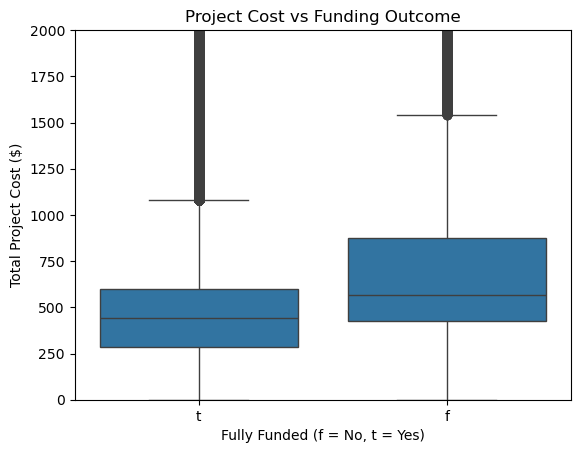

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fully_funded', y='total_price_including_optional_support', data=df)
plt.title('Project Cost vs Funding Outcome')
plt.xlabel('Fully Funded (f = No, t = Yes)')
plt.ylabel('Total Project Cost ($)')
plt.ylim(0, 2000)
plt.show()

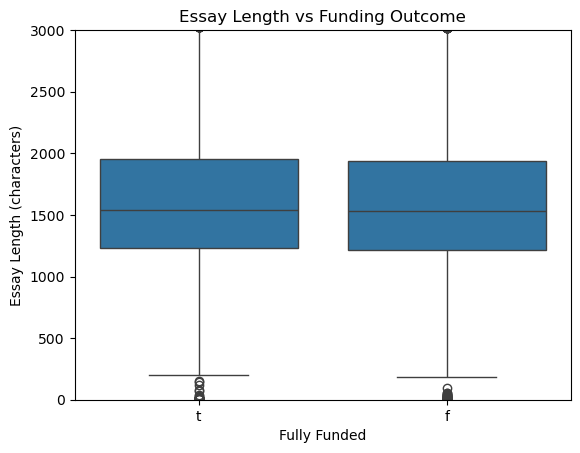

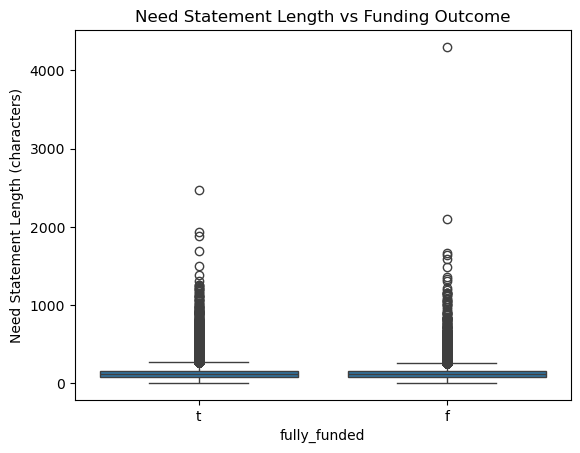

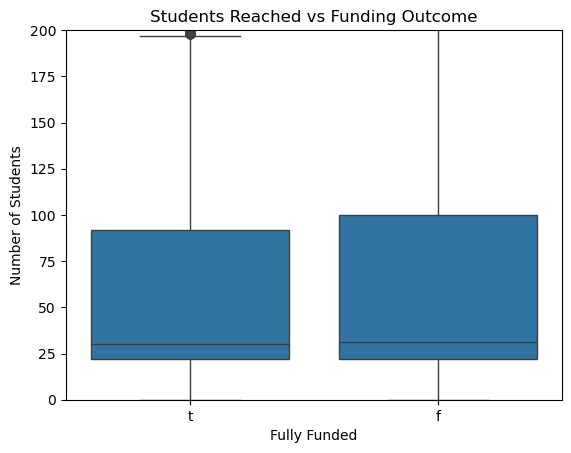

In [46]:
sns.boxplot(x='fully_funded', y='essay_length', data=df)
plt.title('Essay Length vs Funding Outcome')
plt.xlabel('Fully Funded')
plt.ylabel('Essay Length (characters)')
plt.ylim(0, 3000)
plt.show()

sns.boxplot(x='fully_funded', y='need_statement_length', data=df)
plt.title('Need Statement Length vs Funding Outcome')
plt.ylabel('Need Statement Length (characters)')
plt.show()


sns.boxplot(x='fully_funded', y='students_reached', data=df)
plt.title('Students Reached vs Funding Outcome')
plt.xlabel('Fully Funded')
plt.ylabel('Number of Students')
plt.ylim(0, 200)
plt.show()


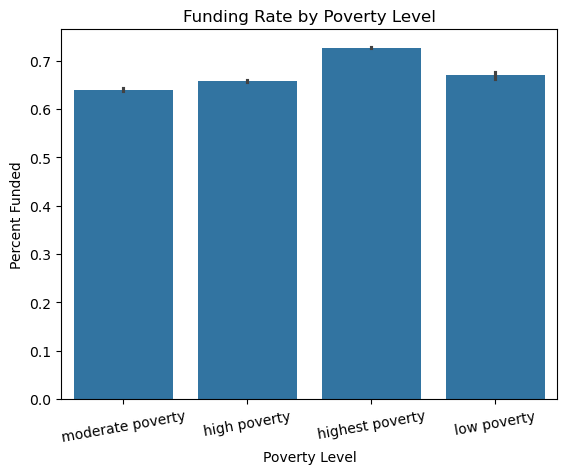

In [47]:

sns.barplot(x='poverty_level', y='fully_funded_bin', data=df)
plt.title('Funding Rate by Poverty Level')
plt.ylabel('Percent Funded')
plt.xlabel('Poverty Level')
plt.xticks(rotation=10)
plt.show()




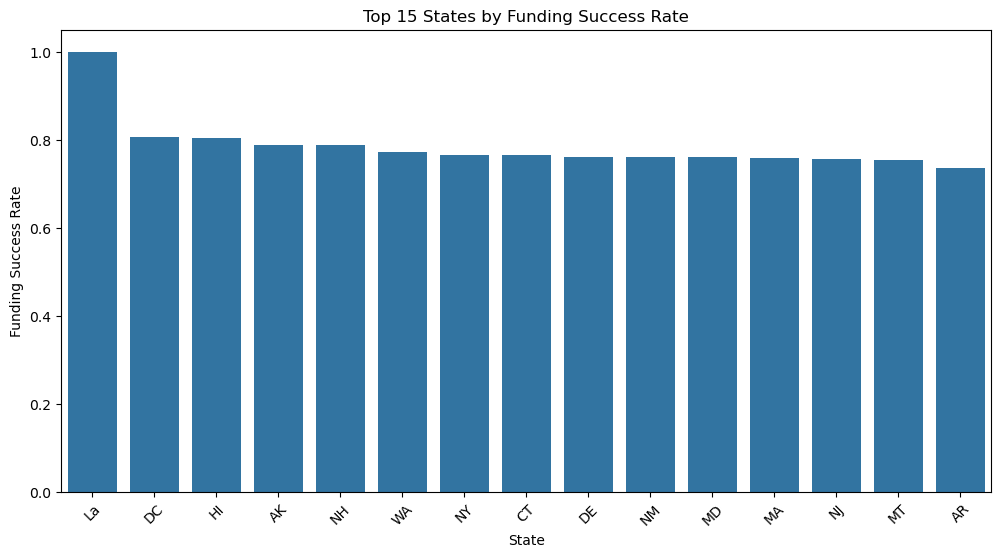

In [48]:
# Group by state
state_success = df.groupby('school_state')['fully_funded_bin'].mean().sort_values(ascending=False)

# Plot top 15 states by funding success
plt.figure(figsize=(12, 6))
sns.barplot(x=state_success.head(15).index, y=state_success.head(15).values)
plt.title('Top 15 States by Funding Success Rate')
plt.xlabel('State')
plt.ylabel('Funding Success Rate')
plt.xticks(rotation=45)
plt.show()

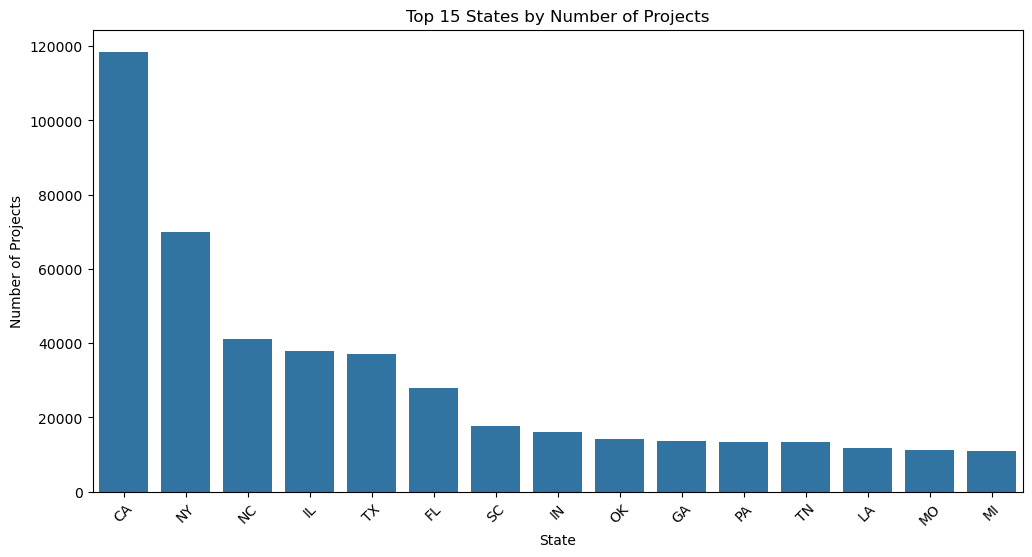

In [49]:
state_counts = df['school_state'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.head(15).index, y=state_counts.head(15).values)
plt.title('Top 15 States by Number of Projects')
plt.xlabel('State')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.show()


**Features**

In [50]:
#CREATE THE FEATURE MATRIX (X) AND LABEL (y)

feature_cols = [
    'total_price_including_optional_support',
    'resource_cost_sum',
    'essay_length',
    'title_length',
    'need_statement_length',
    'poverty_level',
    'school_state',
    'students_reached',
    'resource_type_count'
]

# Drop any rows with missing values in these columns
df_model = df[feature_cols + ['fully_funded_bin']].dropna()

# Create X and y
X = df_model[feature_cols]
y = df_model['fully_funded_bin']
df_model

,total_price_including_optional_support,resource_cost_sum,essay_length,title_length,need_statement_length,poverty_level,school_state,students_reached,resource_type_count,fully_funded_bin
44772,522.78,408.24,1334,34,64,moderate poverty,IL,7.0,1.0,1
44773,274.40,188.98,1109,24,95,high poverty,ID,30.0,1.0,0
44774,335.40,231.34,2297,17,159,moderate poverty,NH,230.0,1.0,0
44775,274.05,59.98,1015,20,100,highest poverty,VA,18.0,1.0,0
44776,604.01,433.55,1937,24,207,highest poverty,IL,70.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...
664093,281.71,0.00,1345,23,75,highest poverty,NY,0.0,1.0,1
664094,1376.83,0.00,2271,66,263,highest poverty,NY,0.0,1.0,1
664095,152.44,0.00,1239,62,75,moderate poverty,NY,0.0,1.0,1
664096,152.44,0.00,2272,150,75,highest poverty,NY,0.0,1.0,1


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder


In [52]:
# One hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['poverty_level', 'school_state'], drop_first=True)


from sklearn.preprocessing import StandardScaler
# Scale numeric features
numeric_cols = [
    'total_price_including_optional_support',
    'resource_cost_sum',
    'essay_length',
    'title_length',
    'need_statement_length',
    'students_reached',
    'resource_type_count'
]
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

In [53]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


In [54]:
print("Feature matrix shape:", X_encoded.shape)
print("distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (619001, 61)
distribution:
 fully_funded_bin
1    0.695621
0    0.304379
Name: proportion, dtype: float64


In [55]:
# ==================== MODELS ====================
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train, y_train)
sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

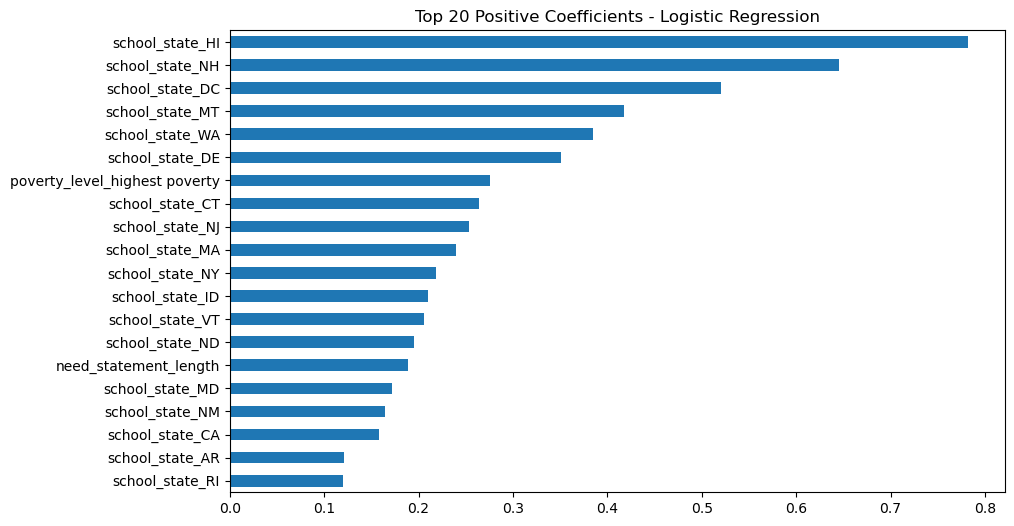

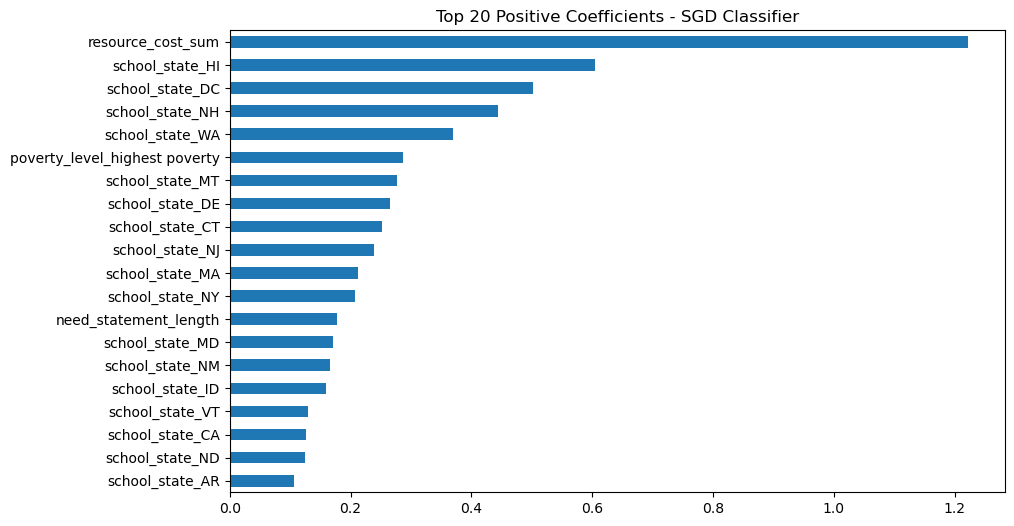

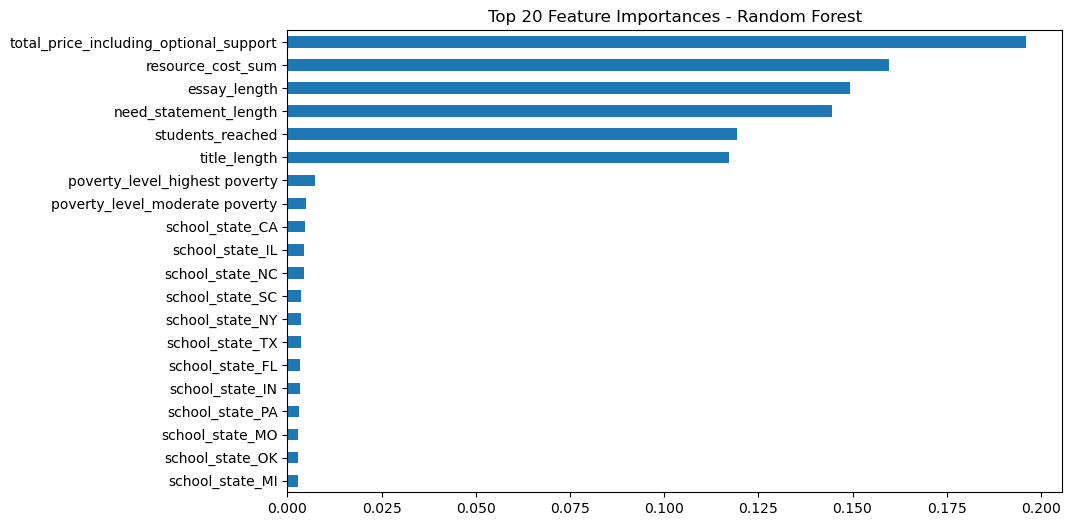

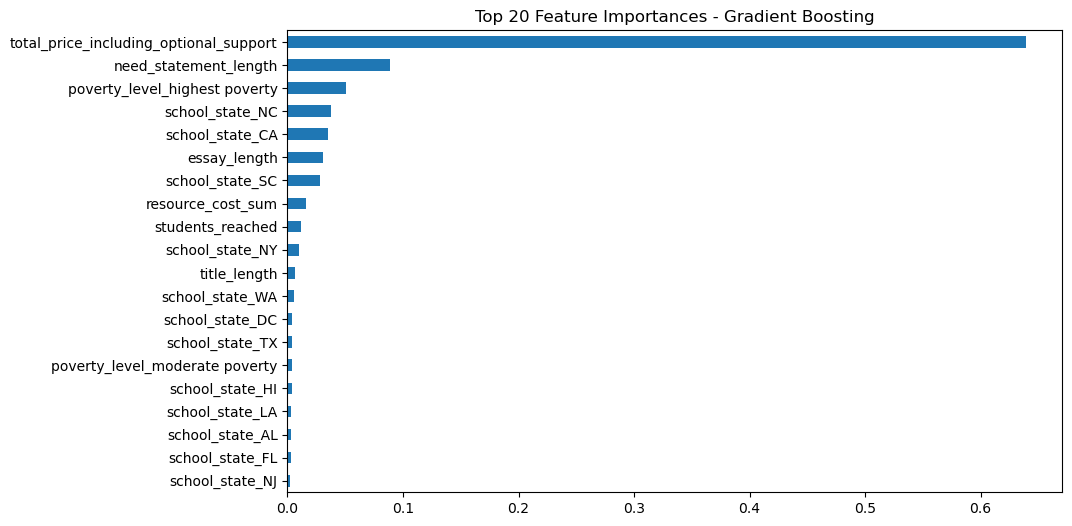

In [58]:
# ==================== FEATURE IMPORTANCE ====================
# Logistic Regression
lr_importance = pd.DataFrame(lr.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lr_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - Logistic Regression")
plt.show()

# SGD
sgd_importance = pd.DataFrame(sgd.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
sgd_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - SGD Classifier")
plt.show()

# Random Forest
rf_importance = pd.DataFrame(rf.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
rf_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

# Gradient Boosting
gb_importance = pd.DataFrame(gb.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
gb_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Gradient Boosting")
plt.show()

## Feature Importance Highlights

### 1. Logistic Regression
- **Most positively associated with success:**
  - `school_state_HI`, `school_state_NH`, `school_state_DC`
  - `poverty_level_highest poverty`
- Strong presence of **school_state** dummy variables shows that **geographic location** has high predictive power in linear separation.
- Also, `need_statement_length` appears to be relevant.

---

### 2. SGD Classifier
- Similar to Logistic Regression, but with **`resource_cost_sum`** as the top coefficient.
- High variance in coefficients (e.g., 1.2 for resource cost), possibly due to **regularization differences**.
- **State features** and `need_statement_length` are again **prominent**.

---

### 3. Random Forest
- **Top features:**
  - `total_price_including_optional_support`
  - `resource_cost_sum`
  - `essay_length`, `need_statement_length`, `students_reached`
- Tree-based models focus more on **numeric and continuous features**.
- **School states** and **poverty level dummies** rank lower — likely due to less consistent impact across decision splits.

---

### 4. Gradient Boosting
- **Dominated by**: `total_price_including_optional_support` (massively high importance)
- Next most important:
  - `need_statement_length`
  - `poverty_level_highest poverty`
  - A few `school_state` variables
- Suggests that **cost** and **poverty severity** are especially powerful when boosting decision trees.


In [59]:
# ==================== EVALUATION ====================
y_probs = {
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'Gradient Boosting': gb.predict_proba(X_test)[:, 1],
    'SGD Classifier': sgd.predict_proba(X_test)[:, 1],
    'KNN': knn.predict_proba(X_test)[:, 1],
}

results = pd.DataFrame({
    'Model': list(y_probs.keys()),
    'ROC AUC': [roc_auc_score(y_test, prob) for prob in y_probs.values()]
})
print(results)

                 Model   ROC AUC
0  Logistic Regression  0.660671
1        Random Forest  0.698822
2    Gradient Boosting  0.700177
3       SGD Classifier  0.646942
4                  KNN  0.552692


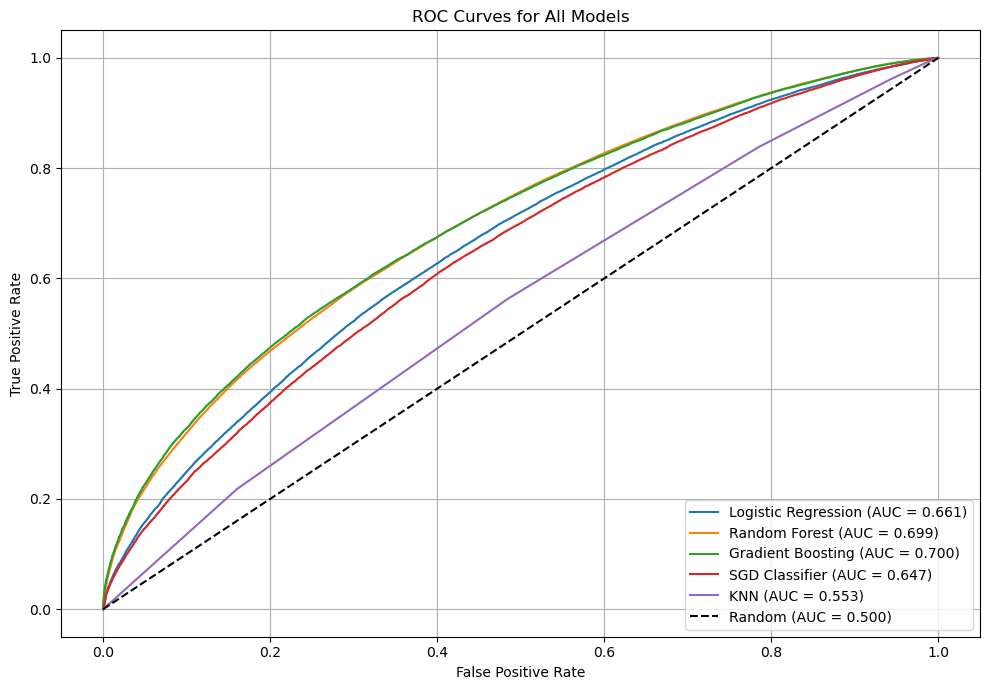

In [60]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

for model_name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
